The entire code was heavily inspired by https://github.com/MadryLab/photoguard.git

# **Step 1: Initialization**

In [3]:
from PIL import Image, ImageOps
import requests
import numpy as np
import torch
from tqdm import tqdm
import os
import torchvision.transforms as T

In [ ]:
!huggingface-cli login

In [4]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00


In [5]:
from diffusers import StableDiffusionImg2ImgPipeline


# **Step 2: Preparing the image**

In [6]:
to_pil = T.ToPILImage()

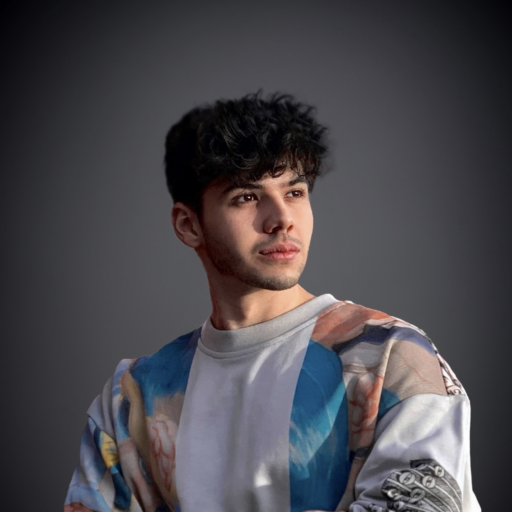

In [7]:
#get the desired image
init_image = Image.open("/content/drive/MyDrive/Colab Notebooks/assets/Face Pictures/FaceImage.jpg").convert('RGB')

#Resize the image
resize = T.transforms.Resize(512)
center_crop = T.transforms.CenterCrop(512)
init_image = center_crop(resize(init_image))
init_image

#Resize the image
#resize = T.transforms.Resize(512)
#init_image_resized = resize(init_image)

#width, height = init_image_resized.size
#right_crop = init_image_resized.crop((width - 512, 0, width, height))

#init_image = right_crop
#init_image

In [8]:
print(type(init_image))
print(init_image)

<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7BFEBF518640>


In [9]:
#initilaize the model

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe_img2img = pipe_img2img.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# **Step 2: Image Preprocessing**

In [ ]:
# preprocess function ensures that the input image is appropriately resized, normalized, and formatted to be compatible with the expectations of the deep learning model for the adversarial attack.

In [10]:
def preprocess(image):
    #resize the image to be compatible with the model input
    width, height = image.size
    width, height = map(lambda x: x - x % 32, (width, height))  # Many deep learning models especially those based on CNNs work efficiently with input sizes that are multiples of 32 that's why resize to an integer multiple of 32
    image = image.resize((width, height), resample=Image.LANCZOS) # Resampling using the Lanczos filter helps preserve image details
    image = np.array(image).astype(np.float32) / 255.0 # The pixel values of the image are converted to floating-point numbers and normalized to the range [0, 1], this helps stabilize the training process
    image = image[None].transpose(0, 3, 1, 2) #adding a singleton dimension at the beginning using None to be compatible with the expected input format
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

# **Step 3: Encoder Attack Implementation**

In [11]:
def pgd(X, model, eps=0.1, step_size=0.015, iters=40, clamp_min=0, clamp_max=1):
  # clamp_min=0 and clamp_max=1 are to keep the pixel values at [0, 1]
  # eps specifies the maximum allowable perturbation to maintain imperceptibility. It limits the magnitude of changes applied to the input data so that the perturbed data remains visually similar
  # a larger step size leads to faster convergence but might result in noticable perturbations. A smaller step size might require more iterations but might create less perceptible changes. The trick is finding the perfect spot where the convergence is fast enough but the perturbations can't be deteceted with the human eye

    X_adv = X.clone().detach() + (torch.rand(*X.shape) * 2 * eps - eps).cuda() # X_adv is initialized by perturbing the original input X with random noise

    pbar = tqdm(range(iters))
    for i in pbar:
        actual_step_size = step_size - (step_size - step_size / 100) / iters * i #decreases step size dynamically to reduce perturbation magnitude

        X_adv.requires_grad_(True) #enables the computation of gradients, crucial for gradient descent attack

        # Modify loss function to target specific features or representations

        loss = (model(X_adv).latent_dist.mean).norm()

        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f} | step size: {actual_step_size:.4}") #progress bar

        grad, = torch.autograd.grad(loss, [X_adv])


        # Perturb the image based on the gradient
        X_adv = X_adv - grad.detach().sign() * actual_step_size #.sign() maximizes loss
        X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps ) #The values of the adversarial example are clamped to ensure that they stay within a feasible range to prevent the generation of adversarial examples that are too different from the original input.
        X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)
        X_adv.grad = None #zero out any accumulated gradient information from previous iterations


    return X_adv

# **Step 4: Executing the attack**

In [12]:
with torch.autocast('cuda'):
    X = preprocess(init_image).half().cuda()
    adv_X = pgd(X,
                model=pipe_img2img.vae.encode,
                clamp_min=-1,
                clamp_max=1,
                eps=0.4,  # Adjust the perturbation range for more noticeable disruptions
                step_size=0.000001,
                iters=700,
               )

    # Convert pixels back to [0,1] range
    adv_X = (adv_X / 2 + 0.5).clamp(0, 1)

[Running attack]: Loss 517.23969 | step size: 1.141e-08: 100%|██████████| 700/700 [04:04<00:00,  2.86it/s]


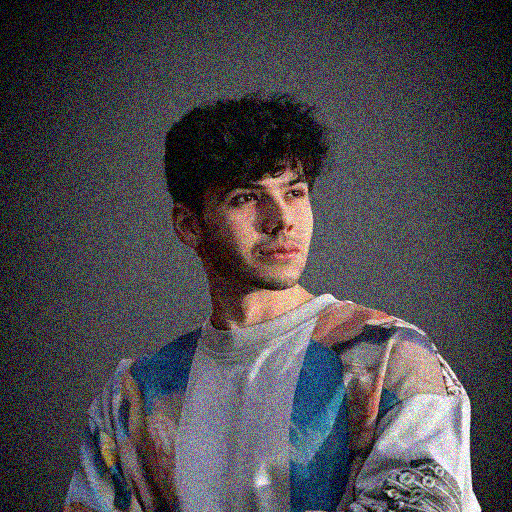

In [13]:
adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/assets/Face Pictures/adv_image.jpg"  # Define the file path and name for the image

adv_image.save(file_path)